In [1]:
import open3d as o3d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['figure.dpi'] = 150
import copy

In [2]:
# input the point cloud
# replace this point cloud with your point cloud.
pcd = o3d.io.read_point_cloud("Model/18inch_obj.ply")
pcd.normalize_normals()
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=200, origin=[0,0,0])

normal = np.asarray(pcd.normals)
points = np.asarray(pcd.points)

### Extract the upper surface point clouds
First, use coordinates to extract the upper surface point clouds. Then, project the 3d points into the y-z plane and assign box index through voxel division. Finally, choose the point in each voxel whose x coordinate is the biggest.

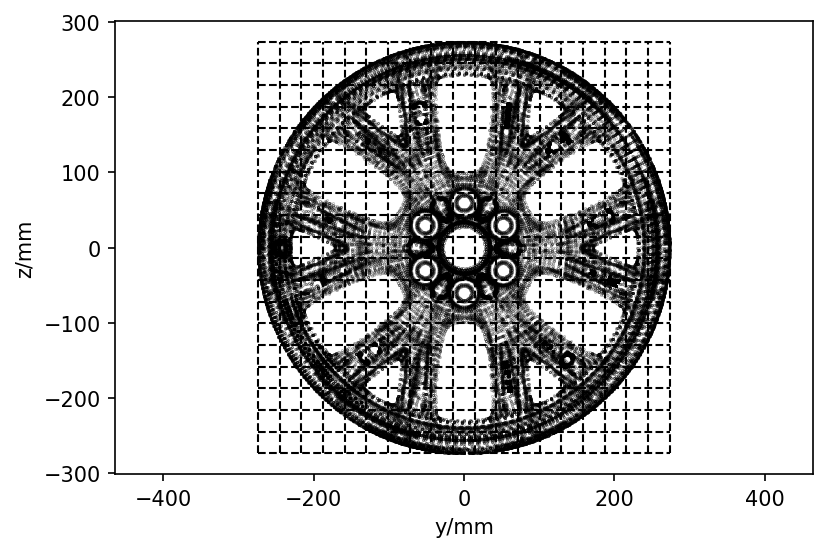

In [3]:
# box
y_min = np.min(points[:,1])
y_max = np.max(points[:,1])
z_min = np.min(points[:,2])
z_max = np.max(points[:,2])
n = 50
yr = (y_max - y_min)/n
zr = (z_max - z_min)/n
gridy = np.linspace(y_min,y_max,20)
gridz = np.linspace(z_min,z_max,20)

# show the voxel division 
plt.scatter(points[:,1],points[:,2],s = 0.01,color='k')
for i in range(gridy.shape[0]):
    plt.plot([gridy[i]]*2,[z_min,z_max],'k--',linewidth = 1)
for i in range(gridz.shape[0]):
    plt.plot([y_min,y_max],[gridz[i]]*2,'k--',linewidth = 1)
plt.axis('equal')
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

In [13]:
# assgin box index to all points
dic = {}
for i in range(points.shape[0]):
    p = points[i]
    t = (np.floor((p[1]-y_min)/yr),np.floor((p[2]-z_min)/zr))
    if t in dic:
        dic[t].append(i)
    else:
        dic[t] = [i]

In [14]:
# extract the upper surface
#     normal_x >0
#     x >25
#     within a small range of the point with maximum x in each box: \xmax-x\<e
remain_index = []# points index
e = 10
for i in dic.keys():
    index_set = dic[i]
    t = [] # points index
    for j in index_set:
        if normal[j][0] > 0:
            if points[j][0] > 25:
                t.append(j)
#     remain_index.extend(t)
    if t != []:
        t_points = np.asarray([points[k] for k in t]) # points
        t_max_x = np.max(t_points[:,0]) # max_x
        t_index = np.where(t_points[:,0]>(t_max_x-e))[0] # index of t
        remain_index.extend([t[k] for k in t_index]) # points index from desired index of t
            
pcd_remain = pcd.select_by_index(remain_index)
# #  show the point cloud of upper surface
# o3d.visualization.draw_geometries([pcd_remain,mesh_frame],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024],
#                                   point_show_normal=False)
# o3d.io.write_point_cloud('../Model/18inch_obj_upper_surface.ply',pcd_remain)

remain_points = np.asarray(pcd_remain.points)
remain_normals = np.asarray(pcd_remain.normals)

In [15]:
def plot_image(section, path = None, cmap_name = 'Greys', cv_map = None):
    matplotlib.rcParams['figure.dpi'] = 100
    x=np.arange(0,section.shape[1])
    y=np.arange(0,section.shape[0])
    X,Y=np.meshgrid(x,y)
    Z=section
    fig,ax = plt.subplots()
    cmap = plt.get_cmap(cmap_name)
    if cv_map is None:
        levels = MaxNLocator(nbins=100).tick_values(Z.min(),Z.max())
    else:
        levels = MaxNLocator(nbins=100).tick_values(cv_map[0],cv_map[1])
    norm = BoundaryNorm(levels, ncolors=cmap.N)
    ax.pcolormesh(X-0.5, Y-0.5, Z,shading='auto',cmap=cmap, norm=norm)
    ax.set_aspect('equal', 'box')
    if path is not None:
        for i in range(len(path)):
            ax.plot(path[i][0],path[i][1],color = 'r')
            for j in range(int(len(path[i][0])/2)):
                if (path[i][0][2*j+1]-path[i][0][2*j]) != 0 or (path[i][1][2*j+1]-path[i][1][2*j]) != 0:
                    ax.quiver(path[i][0][2*j],path[i][1][2*j],(path[i][0][2*j+1]-path[i][0][2*j])/2,(path[i][1][2*j+1]-path[i][1][2*j])/2)
                    break
    plt.show()

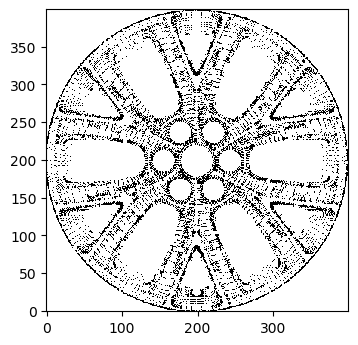

In [16]:
y_min = np.min(remain_points[:,1])
y_max = np.max(remain_points[:,1])
z_min = np.min(remain_points[:,2])
z_max = np.max(remain_points[:,2])
n = 400
yr = (y_max - y_min)/n
zr = (z_max - z_min)/n
dic = {}
section_yz = np.zeros(shape = (n+1,n+1))
for i in range(remain_points.shape[0]):
    p = remain_points[i]
    t = (int(np.floor((p[1]-y_min)/yr)),int(np.floor((p[2]-z_min)/zr)))
    if t in dic:
        dic[t].append(i)
    else:
        dic[t] = [i]
        section_yz[int(t[0]),int(t[1])] = 1
        
# show the projection of the upper surface 
plot_image(section_yz)

### Alpha Shape through Delaunay Triangle
The main idea of alpha shape is to use the circle with $\alpha$ radius to roll along a set of points while no point is inside the circle all the time and the points contacting the circle form the boundary. 

The basic idea is to check every two point pair. One edge consisting of these two points is the boundary, if 
- the length is smaller than $2\alpha$
- one of two circles passing these two points contains no other points in the point set

However, the complexity is too big. Here is a modified algorithm.

- **Step 1:** Generate delaunay triangle network.
- **Step 2:** Delete the triangle if one of the edges satisfies one of following condition
 - the length is smaller than $2\alpha$
 - both of two circles passing end points of the edge contain the other point of the triangle
- **Step 3:** Find the boundary of the triangle network. The method can be 
 - if the number of triangles sharing one certain edge is 1, this edge is the boundary
- **Step 4:** Connect the boundary edges to form the contour with **Depth First Search** (DFS).

And for the **Step 2**, there is no need to check each edge, instead check the longest edge.

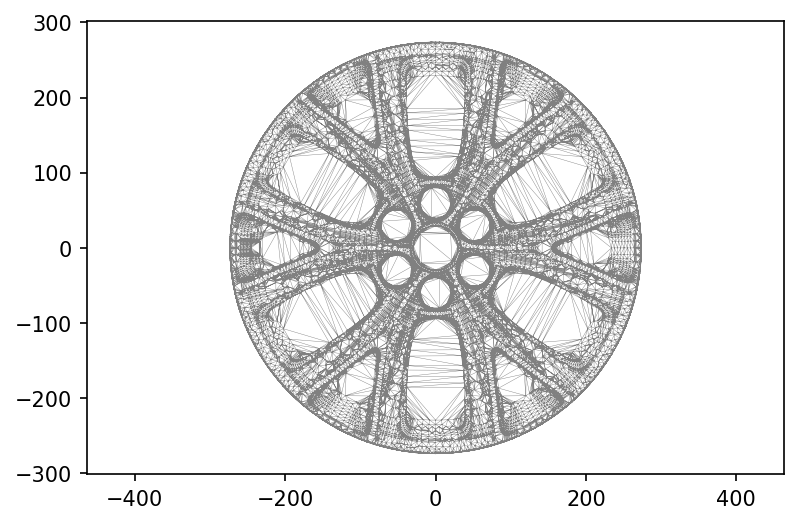

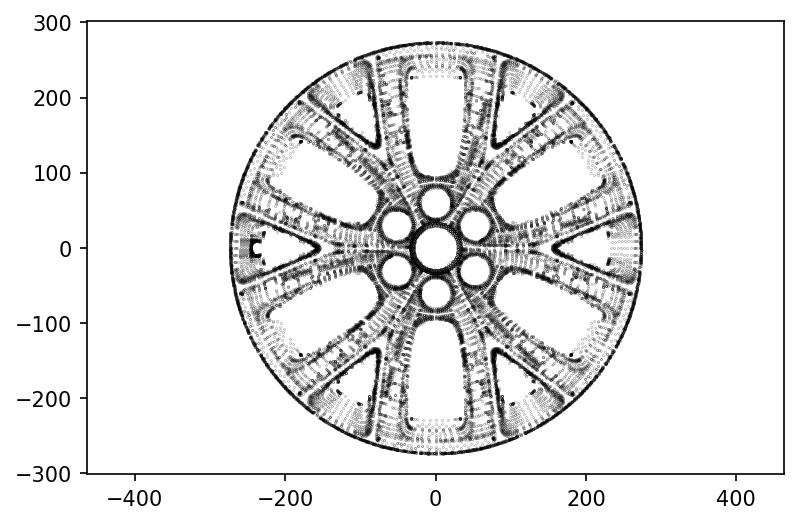

In [17]:
from scipy.spatial import Delaunay
remain_points_yz = np.array(remain_points[:,1:])
matplotlib.rcParams['figure.dpi'] = 150
# nx2 matrix
tri = Delaunay(remain_points_yz)

# show triangle network
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],tri.simplices.copy(),linewidth = 0.2,color = np.ones(3)*0.5)
plt.axis('equal')
plt.show()

# show point cloud
plt.scatter(remain_points_yz[:,0],remain_points_yz[:,1],s=0.01,color = 'k')
plt.axis('equal')
plt.show()

In [18]:
# alpha shapes
alpha = 6
tri_set = tri.simplices.copy()
del_set = []
for i in range(len(tri_set)):
    index = tri_set[i]
    p = [remain_points_yz[index[j]] for j in range(3)]
    l = []
    for j in range(3):
        if j != 2:
            l.append((np.sum((p[j+1]-p[j])**2))**0.5)
        else:
            l.append((np.sum((p[2]-p[0])**2))**0.5)
    max_l = np.max(l)
    max_index = l.index(max_l)
    if max_l > 2*alpha:
        del_set.append(i)
    else:
        rp = []
        sp = []
        if max_index == 2:
            rp = [p[2],p[0]]
            sp = p[1]
        else:
            rp = [p[max_index],p[max_index+1]]
            if max_index == 1:
                sp = p[0]
            else:
                sp = p[2]
            mid = (rp[0]+rp[1])/2
            slope = rp[0]-rp[1]
            if slope[1] != 0:
                k = np.array([1,-slope[0]/slope[1]])
            else:
                k = np.array([0,1])
            d = (alpha**2 - max_l**2/4)**0.5
            c1 = mid - d*k/(np.sum(k**2))**0.5
            c2 = mid + d*k/(np.sum(k**2))**0.5
            if (np.sum((sp - c1)**2))**0.5 < alpha and (np.sum((sp - c2)**2))**0.5 < alpha:
                del_set.append(i)

      

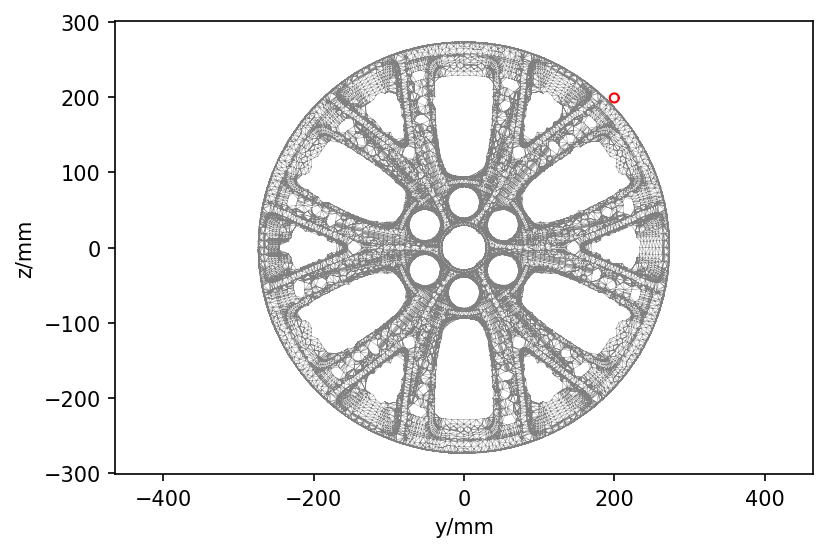

In [19]:
new_tri_set = np.delete(tri_set,del_set,axis = 0)
matplotlib.rcParams['figure.dpi'] = 150
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2,color = np.ones(3)*0.5)
plt.axis('equal')

# an example of the circle to do the AlphaShape
circle_c = [200,199]
circle_angle = np.linspace(0,2*np.pi,100)
circle_x = circle_c[0]+np.cos(circle_angle)*alpha
circle_y = circle_c[1]+np.sin(circle_angle)*alpha
plt.plot(circle_x,circle_y,'r',linewidth = 1)
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

### Find the Contour from Triangle Network

Set the number of points is $n$.

- create a $n \times n$ zero matrix $M$, and sort the indice of the end points of each edge, $(i,j), i < j$. Then, $M(i,j) = M(i,j) +1$ for each edge $(i,j)$. Finally, find the boundary edge $(i^*,j^*)$ if $M(i,j) == 1$.
- create the point connection dictionary $dic[i] = [j_0,j_1,...,j_m]$ and $(i, j_k), k \in \{0,1,2,...,m\}$ are boundary edges. 
- DFS to find the contour
 1. initial the current point index $s$, visited point index set $visited$ and contour $c$.
 2. add $s$ into $visited$ and $c$. For each value $v$ in $dic[s]$,
   - if $v$ is not in $visited$, $s = v$, return to 2.

In [20]:
from collections import defaultdict
point = copy.deepcopy(new_tri_set)

print('Creating edges set...')
n = np.max(point)
mat = np.zeros(shape = (n+1,n+1))
for i in range(point.shape[0]):
    if i % 10000 == 0:
        print(i*100/len(point),' %')
    for j in range(3):
        if j == 2:
            index = sorted([point[i][0],point[i][2]])
            mat[index[0],index[1]] += 1
        else:
            index = sorted([point[i][j],point[i][j+1]])
            mat[index[0],index[1]] += 1

contour_lines = np.asarray(np.where(mat == 1))

# create the edge dic
dic = defaultdict(list)
for i in range(contour_lines.shape[1]):
    ele = contour_lines[:,i]
    dic[ele[0]].append(ele[1])
    dic[ele[1]].append(ele[0])

# dfs
res, visited = [], set()

def dfs(s):
    visited.add(s)
    tem.append(s)
    for end in dic[s]:
        if end not in visited:
            dfs(end)       

for i in range(contour_lines.shape[1]):
    elem = contour_lines[:,i]
    if elem[0] not in visited:
        tem = []
        dfs(elem[0])
        res.append(tem)
       
    
# delete some contours with a few points.
l = []
for i in res:
    l.append(len(i))
l.index(np.max(l))
print('max_num:', l[l.index(np.max(l))],'num_set:',len(l), 'num >20:', np.sum(np.asarray(l)>20))
index = np.where(np.asarray(l) > 20)[0]
print(index)
nums = []
for i in range(len(index)):
    nums.append(len(res[index[i]]))
print(nums)

Creating edges set...
0.0  %
13.906851905934055  %
27.81370381186811  %
41.72055571780216  %
55.62740762373622  %
69.53425952967027  %
83.44111143560433  %
97.34796334153837  %
max_num: 719 num_set: 92 num >20: 20
[ 0  1  6 70 71 73 74 75 77 78 79 80 81 82 83 85 86 88 90 91]
[50, 58, 719, 50, 44, 46, 47, 43, 52, 38, 43, 36, 43, 39, 78, 83, 79, 78, 89, 80]


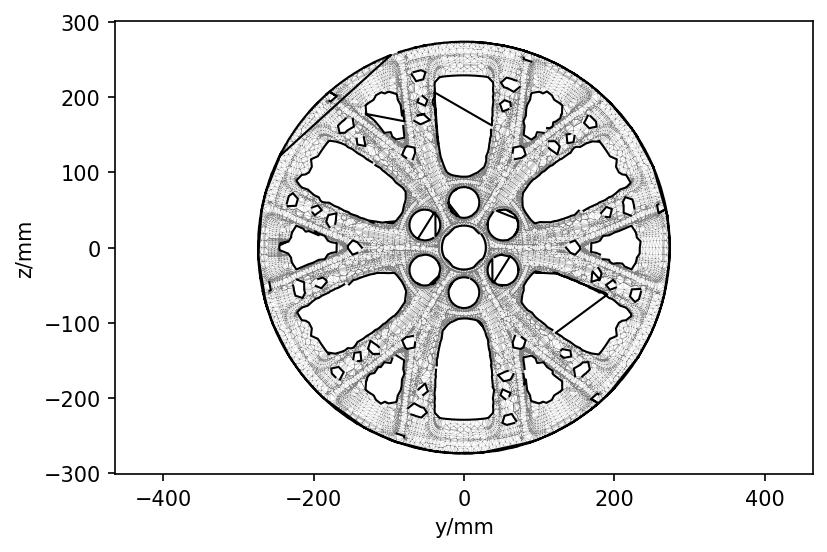

In [21]:
# the color of triangle
tri_color = np.ones(3)*0.5
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.1,color = tri_color)

# plot contour
for i in range(len(l)):
    x = [remain_points_yz[j][0] for j in res[i]]
    y = [remain_points_yz[j][1] for j in res[i]]
    plt.plot(x,y,color = 'k',linewidth = 1)

plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.axis('equal')
plt.show()

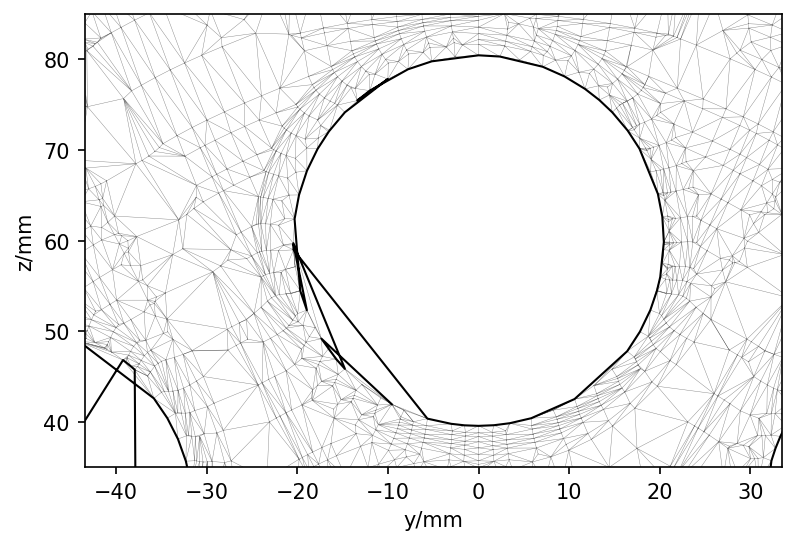

In [22]:
# details
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2,color = tri_color)

for i in range(len(index)):
    x = [remain_points_yz[j][0] for j in res[index[i]]]
    y = [remain_points_yz[j][1] for j in res[index[i]]]
    plt.plot(x,y,'k',linewidth = 1)
plt.axis('equal')
plt.xlim(-30,20)
plt.ylim(35, 85)
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

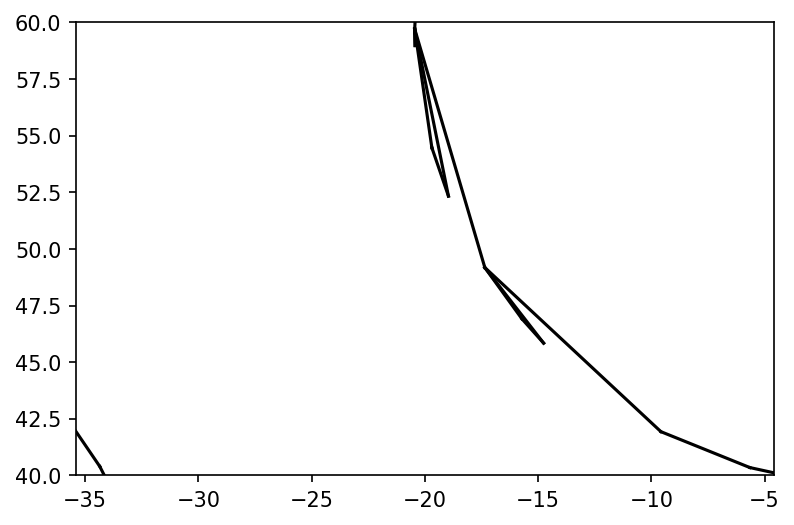

In [24]:
# all the lines 
for i in range(contour_lines.shape[1]):
    x = [remain_points_yz[contour_lines[0,i],0],remain_points_yz[contour_lines[1,i],0]]
    y = [remain_points_yz[contour_lines[0,i],1],remain_points_yz[contour_lines[1,i],1]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlim(-30,-10)
plt.ylim(40, 60)
plt.show()

### Find the Contour from Triangle Network

Set the number of points is $n$.

- create a $n \times n$ zero matrix $M$, and sort the indice of the end points of each edge, $(i,j), i < j$. Then, $M(i,j) = M(i,j) +1$ for each edge $(i,j)$. Finally, find the boundary edge $(i^*,j^*)$ if $M(i,j) == 1$.
- create the point connection dictionary $dic[i] = [j_0,j_1,...,j_m]$ and $(i, j_k), k \in \{0,1,2,...,m\}$ are boundary edges. 
- DFS to find the contour
 1. initial the current point index $s$, visited point index set $visited$ and contour $c$.
 2. add $s$ into $visited$ and $c$. For each value $v$ in $dic[s]$,
   - if $v$ is not in $visited$, $s = v$, return to 2.

This method does not work. Traditional DFS terminates when all the surrounding points are searched. This cannot guarantee return the contour which means the start point and the end point are the same. So the modified version of DFS terminates when next point is the start point and return all the possible paths. And choose the path with the maximum number of the points.

**Pseudo Code**:

Initial the start point index $s$ and end point $e$, visited point index set $visited = set()$, current contour $c = []$.

def $find\_contour\_all(dic, s, e, visited, c)$:
- add $s$ into $c$, which means $c = c + [s]$
- if number of points in $c$ is more than 1 and $c[0] == c[-1]$, return $cs = [c]$
- initial contour set $cs = []$.
- for each value $v$ in $dic[s]$, if $v$ not in $c[1:]$, $nc = find\_contour\_all(dic, v, e, visited, c)$.
  - for $tc$ in $nc$, $cs.append(tc)$
- return $cs$


0.0 %
4.120313143798929 %
8.240626287597857 %
12.360939431396787 %
16.481252575195715 %
20.601565718994642 %
24.721878862793574 %
28.8421920065925 %
32.96250515039143 %
37.08281829419036 %
41.203131437989285 %
45.323444581788216 %
49.44375772558715 %
53.56407086938607 %
57.684384013185 %
61.804697156983934 %
65.92501030078286 %
70.04532344458178 %
74.16563658838072 %
78.28594973217965 %
82.40626287597857 %
86.52657601977751 %
90.64688916357643 %
94.76720230737536 %
98.8875154511743 %
max_num: 84 num_set: 92 num >20: 18
[ 0  1 70 71 73 74 77 78 79 80 81 82 83 85 86 88 90 91]
[47, 59, 38, 37, 45, 37, 46, 39, 38, 37, 42, 40, 79, 80, 78, 79, 84, 77]


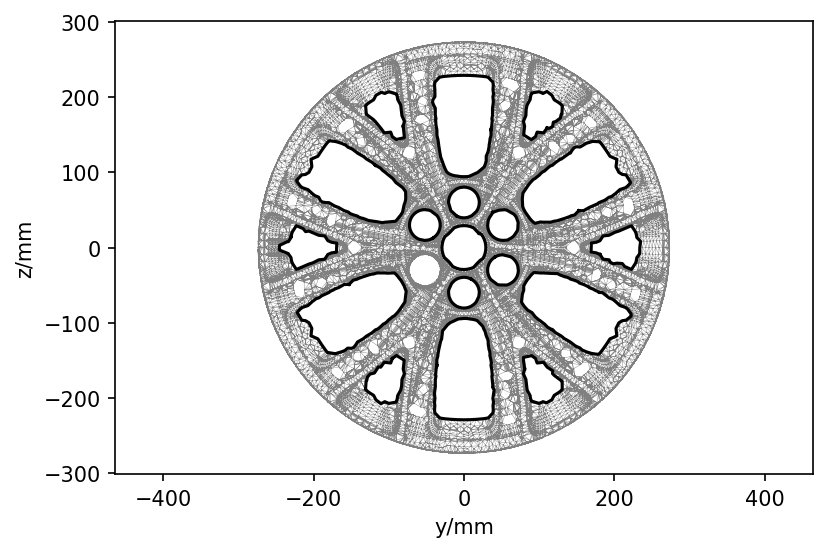

In [25]:
res, visited = [], set()

def find_contour_all(graph,start,end,contour=[]):
    contour = contour +[start]
    if len(contour)>1 and start == end: 
        return [contour]
    visited.add(start)
    contours = []   
    for node in graph[start]:
        if node not in contour[1:]:
            newcontours = find_contour_all(graph,node,end,contour) 
            for newcontour in newcontours:
                contours.append(newcontour)
    return contours

for i in range(contour_lines.shape[1]):
    if i % 100 == 0:
        print(i*100/contour_lines.shape[1],'%')
    elem = contour_lines[:,i]
    if elem[0] not in visited:
        tem = find_contour_all(dic,elem[0],elem[0])
        res.append(tem)
        
final_contour = []
for contour in res:
    l = []
    for pos in contour:
        tl = 0
        if len(pos)>3:
            for i in range(len(pos)):
                if i != len(pos)-1:
                    tl += (np.sum((remain_points_yz[pos[i],:]- remain_points_yz[pos[i+1],:])**2))**0.5
                else:
                    tl += (np.sum((remain_points_yz[pos[0],:]- remain_points_yz[pos[-1],:])**2))**0.5
        l.append(tl)
    final_contour.append(contour[l.index(np.max(l))])

l = []
for i in final_contour:
    l.append(len(i))
l.index(np.max(l))
print('max_num:', l[l.index(np.max(l))],'num_set:',len(l), 'num >20:', np.sum(np.asarray(l)>20))
index = np.where(np.asarray(l) > 20)[0]
print(index)
nums = []
for i in range(len(index)):
    nums.append(len(final_contour[index[i]]))
print(nums)

plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2, color = tri_color)
for i in range(len(index)):
    x = [remain_points_yz[j][0] for j in final_contour[index[i]]]
    y = [remain_points_yz[j][1] for j in final_contour[index[i]]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

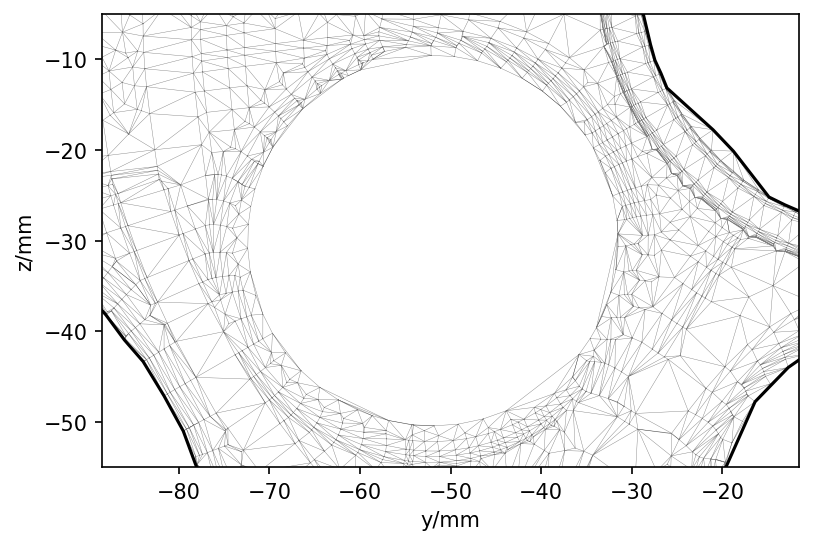

In [26]:
# details
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2, color = tri_color)

for i in range(len(index)):
    x = [remain_points_yz[j][0] for j in final_contour[index[i]]]
    y = [remain_points_yz[j][1] for j in final_contour[index[i]]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlim(-80,-20)
plt.ylim(-55, -5)
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

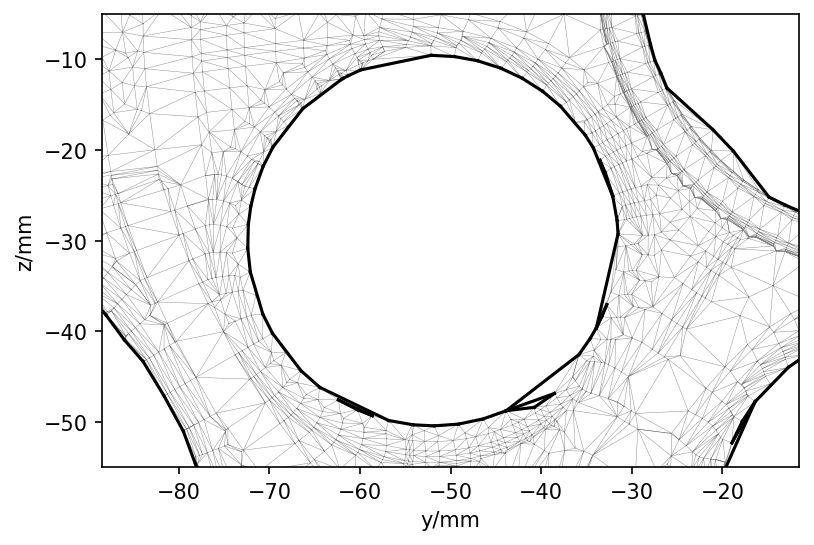

In [27]:
# all the lines
plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2, color = tri_color)

for i in range(contour_lines.shape[1]):
    x = [remain_points_yz[contour_lines[0,i],0],remain_points_yz[contour_lines[1,i],0]]
    y = [remain_points_yz[contour_lines[0,i],1],remain_points_yz[contour_lines[1,i],1]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlim(-80,-20)
plt.ylim(-55, -5)
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

### Find the Contour from Triangle Network

Set the number of points is $n$.

- create a $n \times n$ zero matrix $M$, and sort the indice of the end points of each edge, $(i,j), i < j$. Then, $M(i,j) = M(i,j) +1$ for each edge $(i,j)$. Finally, find the boundary edge $(i^*,j^*)$ if $M(i,j) == 1$.
- create the point connection dictionary $dic[i] = [j_0,j_1,...,j_m]$ and $(i, j_k), k \in \{0,1,2,...,m\}$ are boundary edges. 
- DFS to find the contour
 1. initial the current point index $s$, visited point index set $visited$ and contour $c$.
 2. add $s$ into $visited$ and $c$. For each value $v$ in $dic[s]$,
   - if $v$ is not in $visited$, $s = v$, return to 2.

This method does not work. Traditional DFS terminates when all the surrounding points are searched. This cannot guarantee return the contour which means the start point and the end point are the same. So the modified version of DFS terminates when next point is the start point and return all the possible paths. And choose the path with the maximum number of the points.

**Pseudo Code**:
initial the start point index $s$ and end point $e$, visited point index set $visited = set()$, current contour $c = []$.

def $find\_contour\_all(dic, s, e, visited, c)$:
- add $s$ into $c$, which means $c = c + [s]$
- if number of points in $c$ is more than 1 and $c[0] == c[-1]$, return $cs = [c]$
- initial contour set $cs = []$.
- for each value $v$ in $dic[s]$, if $v$ not in $c[1:]$, $nc = find\_contour\_all(dic, v, e, visited, c)$.
  - for $tc$ in $nc$, $cs.append(tc)$
- return $cs$

This method does not work in some situation. The reason is that if several paths are already found, all the points of these paths are assigned as visited. If several contours overlap and some small contours are found in advance to those big and complete contours, the latter contours will not be found. So if samll contours are found, they should not be accepted, and the points should be assigned as unvisited.


0.0 %
4.120313143798929 %
8.240626287597857 %
12.360939431396787 %
16.481252575195715 %
20.601565718994642 %
24.721878862793574 %
28.8421920065925 %
32.96250515039143 %
37.08281829419036 %
41.203131437989285 %
45.323444581788216 %
49.44375772558715 %
53.56407086938607 %
57.684384013185 %
61.804697156983934 %
65.92501030078286 %
70.04532344458178 %
74.16563658838072 %
78.28594973217965 %
82.40626287597857 %
86.52657601977751 %
90.64688916357643 %
94.76720230737536 %
98.8875154511743 %
max_num: 480 num_set: 20 num >20: 20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[47, 59, 480, 38, 37, 45, 37, 38, 46, 39, 38, 37, 42, 40, 79, 80, 78, 79, 84, 77]


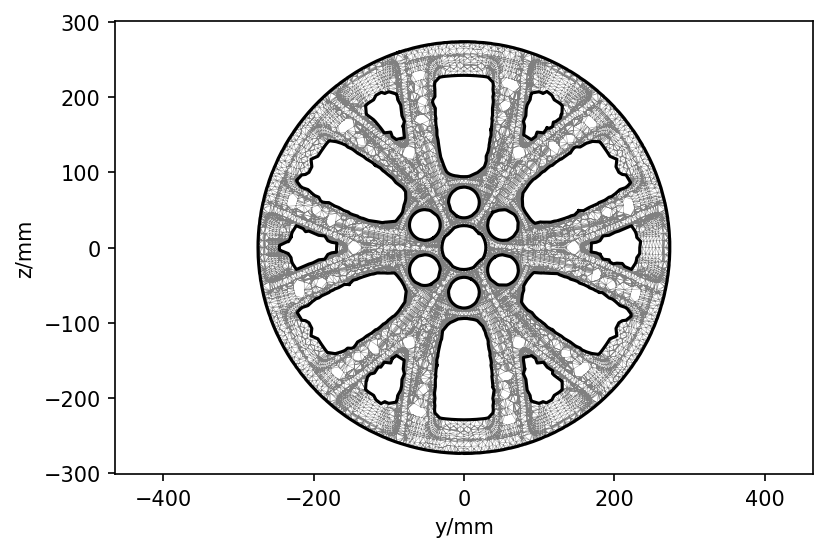

In [28]:
res, visited = [], set()

def find_contour_all(graph,start,end,contour=[]):
    contour = contour +[start]
    if len(contour)>1 and start == end: 
        return [contour]
    visited.add(start)
    contours = []   
    for node in graph[start]:
        if node not in contour[1:]:
            newcontours = find_contour_all(graph,node,end,contour) 
            for newcontour in newcontours:
                contours.append(newcontour)
    return contours

for i in range(contour_lines.shape[1]):
    if i % 100 == 0:
        print(i*100/contour_lines.shape[1],'%')
    elem = contour_lines[:,i]
    if elem[0] not in visited:
        tem = find_contour_all(dic,elem[0],elem[0])
        flag = 1
        for t in tem:
            if len(t) > 20:
                flag = 0
        if flag == 1:
            for t in tem:
                for tt in t:
                    if tt in visited:
                        visited.remove(tt)
        else:
            res.append(tem)
            
final_contour = []
for contour in res:
    l = []
    for pos in contour:
        tl = 0
        if len(pos)>3:
            for i in range(len(pos)):
                if i != len(pos)-1:
                    tl += (np.sum((remain_points_yz[pos[i],:]- remain_points_yz[pos[i+1],:])**2))**0.5
                else:
                    tl += (np.sum((remain_points_yz[pos[0],:]- remain_points_yz[pos[-1],:])**2))**0.5
        l.append(tl)
    final_contour.append(contour[l.index(np.max(l))])
    
l = []
for i in final_contour:
    l.append(len(i))
l.index(np.max(l))
print('max_num:', l[l.index(np.max(l))],'num_set:',len(l), 'num >20:', np.sum(np.asarray(l)>20))
index = np.where(np.asarray(l) > 20)[0]
print(index)
nums = []
for i in range(len(index)):
    nums.append(len(final_contour[index[i]]))
print(nums)

plt.triplot(remain_points_yz[:,0],remain_points_yz[:,1],new_tri_set,linewidth = 0.2, color = tri_color)

for i in range(len(index)):
    x = [remain_points_yz[j][0] for j in final_contour[index[i]]]
    y = [remain_points_yz[j][1] for j in final_contour[index[i]]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

### Extra Codes
calculate the circle with the radius r and passing two points.

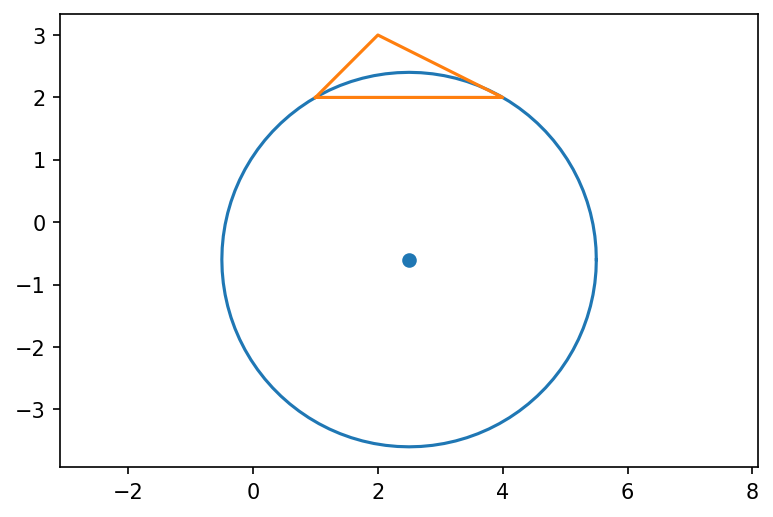

In [33]:
p = [np.array([1,2]),np.array([2,3]),np.array([4,2])]
array_p = p + p[0:1]
array_p = np.asarray(array_p)
l = []
for j in range(3):
    if j != 2:
        l.append((np.sum((p[j+1]-p[j])**2))**0.5)
    else:
        l.append((np.sum((p[2]-p[0])**2))**0.5)
max_l = np.max(l)
    
max_l = np.max(l)
max_index = l.index(max_l)
rp = []
sp = []
if max_index == 2:
    rp = [p[2],p[0]]
    sp = p[1]
else:
    rp = [p[max_index],p[max_index+1]]
    if max_index == 1:
        sp = p[0]
    else:
        sp = p[2]

mid = (rp[0]+rp[1])/2
slope = rp[0]-rp[1]
if slope[1] != 0:
    k = np.array([1,-slope[0]/slope[1]])
else:
    k = np.array([0,1])
r = 3
d = (r**2 - max_l**2/4)**0.5
c = mid - d*k/(np.sum(k**2))**0.5

nr = 100
xr = c[0]+r*np.cos(np.arange(0,2*np.pi+2*np.pi/nr,2*np.pi/nr))
yr = c[1]+r*np.sin(np.arange(0,2*np.pi+2*np.pi/nr,2*np.pi/nr))

plt.scatter(c[0],c[1])
plt.plot(xr,yr)
plt.plot(array_p[:,0],array_p[:,1])
plt.axis('equal')
plt.show()